In [1]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import utils 
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings(action='ignore', category=UserWarning)


c:\Users\franc\miniconda3\envs\tesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Se leen los datos y se seleccionan las variables que presentan una diferencia
# entre los individuos que presentan estres y los que no
data_path = Path(os.getcwd()).parent / "data"
silver_path = data_path / "silver" / "dreadditCleanTrain.csv"
df = pd.read_csv(silver_path)

In [3]:
#Configuracion de visualizaciones 

# Configurar el estilo de fondo con una cuadrícula
sns.set_style("whitegrid")

# Establecer una paleta de colores profesional
sns.set_palette(['#2596be'])

# Configurar la tipografía y el tamaño de la fuente
sns.set_context("paper", font_scale=1.5, rc={"font.family": "sans-serif", "font.sans-serif": ["Helvetica", "Arial"]})

# Desactivar spines innecesarios
sns.despine(trim=True, left=True);

<Figure size 640x480 with 0 Axes>

In [4]:
#df["token_count"] = df.clean_text.apply(lambda x: len(x.split()))

In [5]:

#distribucion de numero de tokens por texto
#g = sns.histplot(x="token_count", data=df, bins=50)
#plt.axvline(df["token_count"].median(), color="orange", alpha=0.8, linestyle="-", label= f"Mediana: {df['token_count'].median()}")
#plt.legend(loc='upper right')
#g.set_title("Cantidad de tokens por texto")
#g.set_xlabel("Número de tokens")
#g.set_ylabel("Frecuencia")

In [6]:
#distribucion de categorias en el label
#label_dis = df.label.value_counts().reset_index()

#g = sns.barplot(x="label", y="count", data=label_dis)
#g.set_title("Distribución de Labels (Estrés =1 / No Estrés = 0)")
#g.set_xlabel("Label")
#g.set_ylabel("Registros")

,singular_pronouns,avg_word_len,lex_diversity,avg_sentence_len,adj_adv
singular_pronouns,1.000000,-0.713628,-0.692381,NaN,-0.509612
avg_word_len,-0.713628,1.000000,0.549119,NaN,0.517746
lex_diversity,-0.692381,0.549119,1.000000,NaN,NaN
avg_sentence_len,NaN,NaN,NaN,1.000000,0.817663
adj_adv,-0.509612,0.517746,NaN,0.817663,1.000000


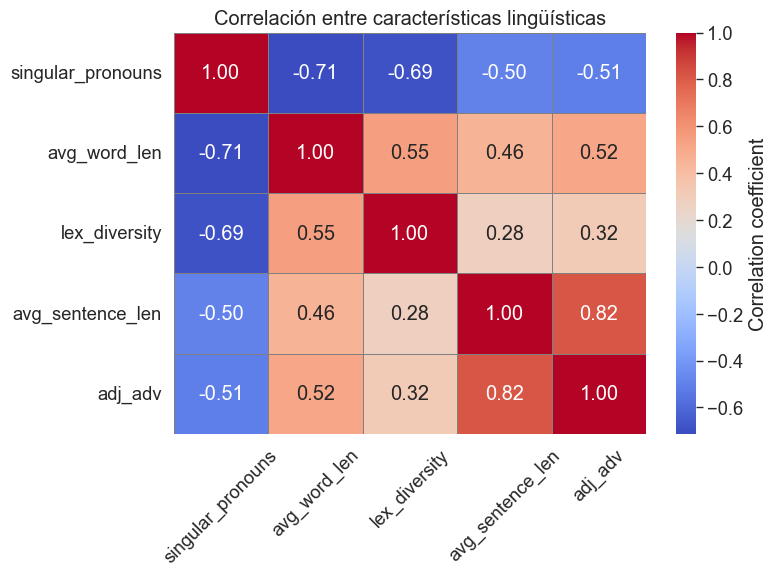

In [7]:
features =['singular_pronouns', 'avg_word_len', 'lex_diversity',
            'avg_sentence_len', 'adj_adv']
X = df.loc[:,features]
y = df.label
feature_corr = X.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))  # Set the figure size for better readability
sns.heatmap(feature_corr, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation coefficient'}, linewidths=.5, linecolor='gray')

plt.title('Correlación entre características lingüísticas')  # Add a title to the heatmap
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels


feature_corr[feature_corr.abs()>0.5]


,singular_pronouns,avg_word_len,lex_diversity,adj_adv
singular_pronouns,1.000000,-0.713628,-0.692381,-0.509612
avg_word_len,-0.713628,1.000000,0.549119,0.517746
lex_diversity,-0.692381,0.549119,1.000000,NaN
adj_adv,-0.509612,0.517746,NaN,1.000000


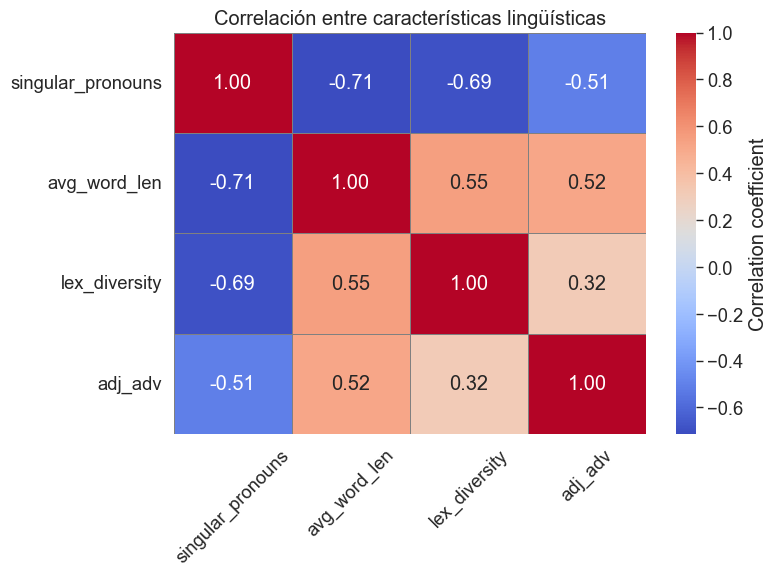

In [8]:
features =['singular_pronouns', 'avg_word_len', 'lex_diversity',
             'adj_adv'] #Se elimina avg_sentence_len
X = df.loc[:,features]
y = df.label
feature_corr = X.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))  # Set the figure size for better readability
sns.heatmap(feature_corr, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation coefficient'}, linewidths=.5, linecolor='gray')

plt.title('Correlación entre características lingüísticas')  # Add a title to the heatmap
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels


feature_corr[feature_corr.abs()>0.5]


,singular_pronouns,lex_diversity,adj_adv
singular_pronouns,1.000000,-0.692381,-0.509612
lex_diversity,-0.692381,1.000000,NaN
adj_adv,-0.509612,NaN,1.000000


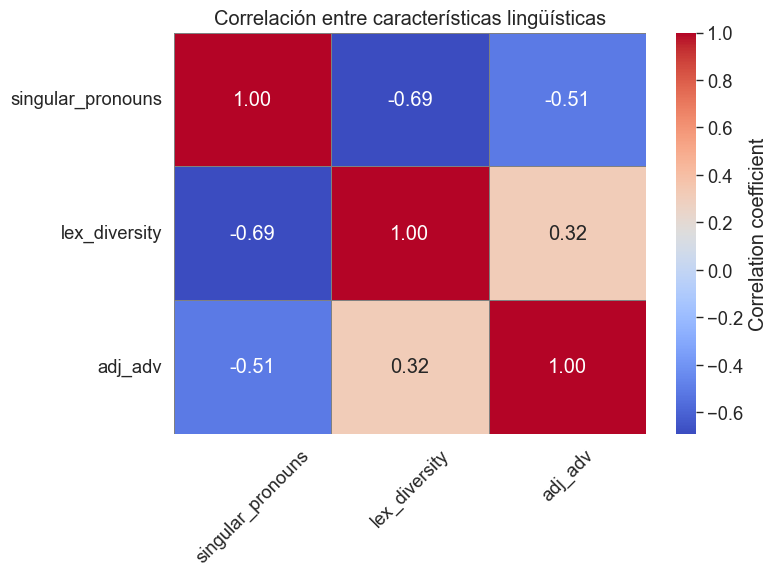

In [9]:
features =['singular_pronouns', 'lex_diversity',
             'adj_adv'] #Se elimina avg_word_len
X = df.loc[:,features]
y = df.label
feature_corr = X.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))  # Set the figure size for better readability
sns.heatmap(feature_corr, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation coefficient'}, linewidths=.5, linecolor='gray')

plt.title('Correlación entre características lingüísticas')  # Add a title to the heatmap
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels


feature_corr[feature_corr.abs()>0.5]

,singular_pronouns,adj_adv
singular_pronouns,1.000000,-0.509612
adj_adv,-0.509612,1.000000


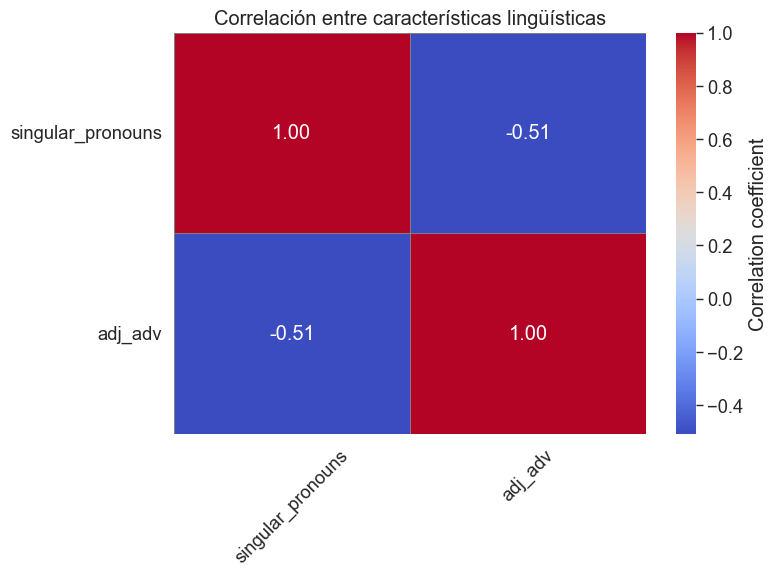

In [10]:
features =['singular_pronouns', 
             'adj_adv'] #Se elimina lex diversity
X = df.loc[:,features]
y = df.label
feature_corr = X.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))  # Set the figure size for better readability
sns.heatmap(feature_corr, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation coefficient'}, linewidths=.5, linecolor='gray')

plt.title('Correlación entre características lingüísticas')  # Add a title to the heatmap
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels


feature_corr[feature_corr.abs()>0.5]

#### **Entrenamiento y evaluacion de modelos**

In [11]:
X.head()

,singular_pronouns,adj_adv
0,0.247312,3.500000
1,0.387097,0.333333
2,0.115385,2.000000
3,0.250000,1.142857
4,0.240741,3.500000


In [12]:
# Get and evaluate models
models = utils.get_models()
results, names = [], []
for name, model in models.items():
    scores = utils.evaluate_model(model, X, y, name, "caracteristicas_manual")
    results.append(scores)
    names.append(name)
    print(f'>{name}: Mean F1 score = {scores.mean():.2f} with Std = {scores.std():.2f}')

>Logistic Regression: Mean F1 score = 0.70 with Std = 0.01
>K-Nearest Neighbors: Mean F1 score = 0.65 with Std = 0.02
>Decision Tree: Mean F1 score = 0.72 with Std = 0.01
>SVM: Mean F1 score = 0.71 with Std = 0.01
>Naive Bayes: Mean F1 score = 0.70 with Std = 0.02
>XGBoost: Mean F1 score = 0.72 with Std = 0.02
>Gradient Boosting: Mean F1 score = 0.72 with Std = 0.01
>Random Forest: Mean F1 score = 0.62 with Std = 0.02
>AdaBoost: Mean F1 score = 0.71 with Std = 0.02


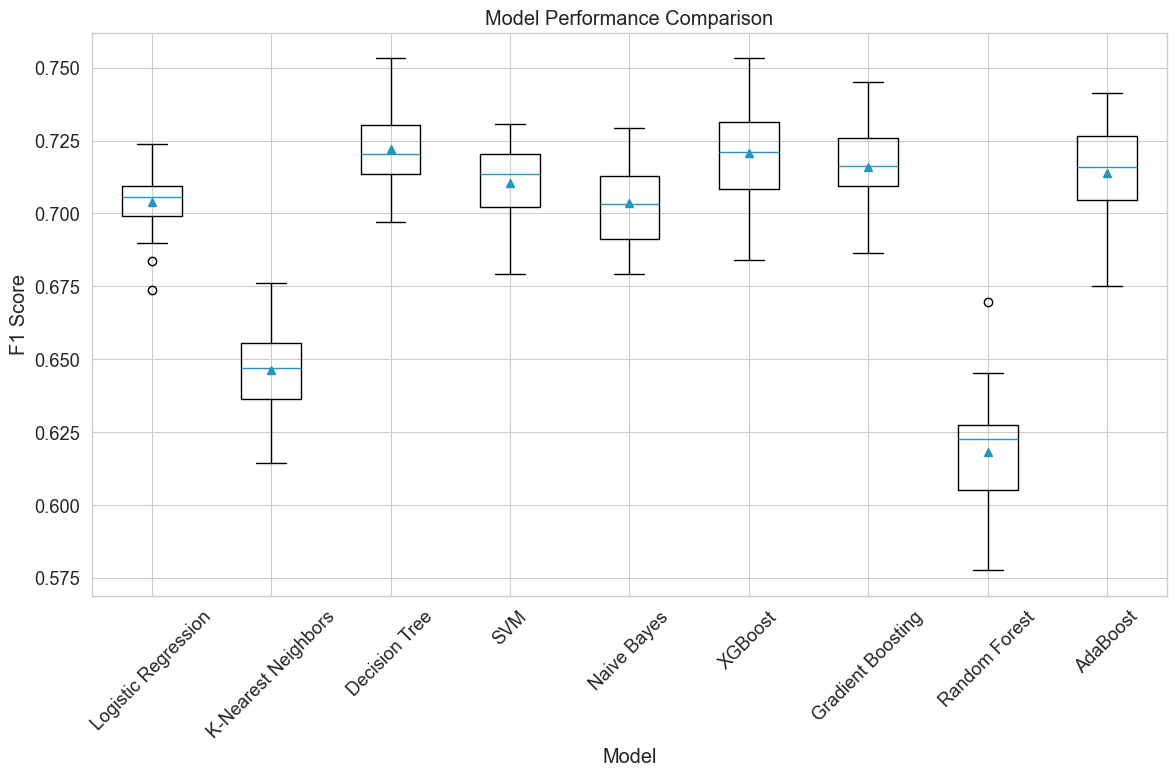

In [13]:
# Plotting model performance for comparison using boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


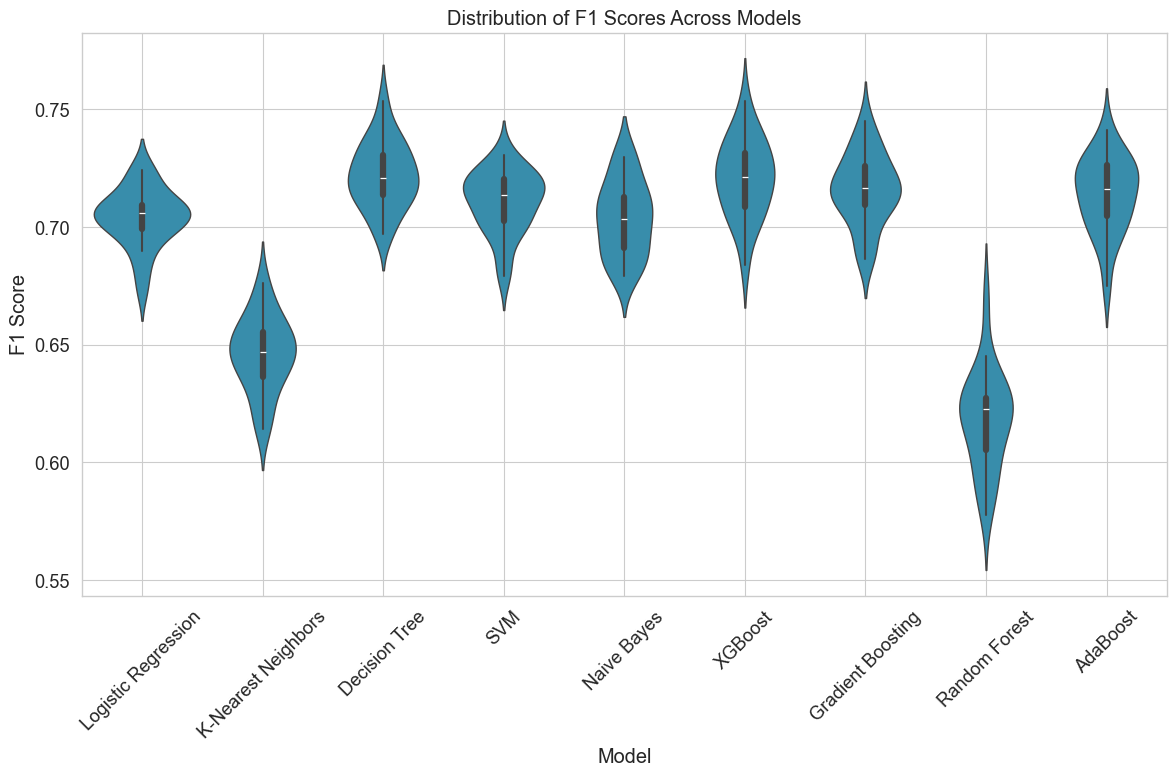

In [14]:
# Create a DataFrame for plotting
data = pd.DataFrame(data={name: scores for name, scores in zip(names, results)})
# Melt the DataFrame for easier plotting with seaborn
data_melted = data.melt(var_name='Model', value_name='F1 Score')

# Create the violin plot
plt.figure(figsize=(12, 8))  # Optional: Adjust the figure size as needed
sns.violinplot(x='Model', y='F1 Score', data=data_melted)
plt.title('Distribution of F1 Scores Across Models')  # Add a title to the plot
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.xlabel('Model')  # Label for the x-axis
plt.ylabel('F1 Score')  # Label for the y-axis
plt.grid(True)  # Optional: Add a grid for better readability
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

#### **Importancia de features**

In [15]:
#Se separan los datos y se entrena un modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier().fit(X_train, y_train)

In [16]:
# Crear el objeto Explainer
explainer = shap.Explainer(model, X_train)
# Calcular SHAP values
shap_values = explainer(X_test)

c:\Users\franc\miniconda3\envs\tesis\lib\site-packages\shap\plots\_force_matplotlib.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


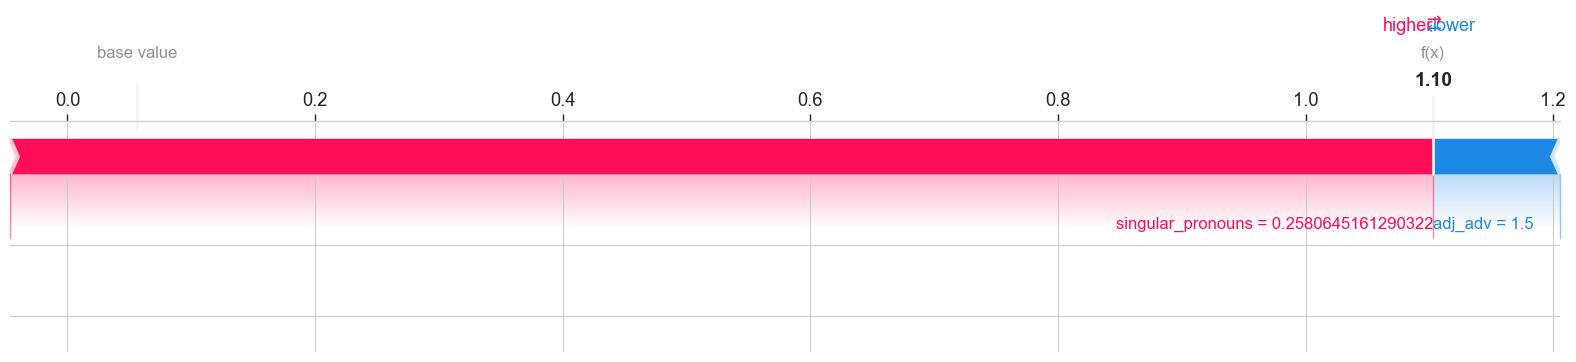

In [17]:
# Visualizar el primer prediccion
shap.plots.force(shap_values[10], matplotlib=True)

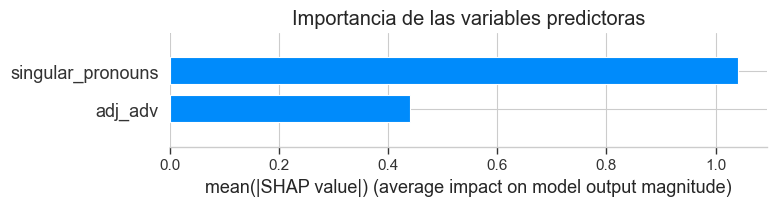

In [18]:
plt.title("Importancia de las variables predictoras")
shap.summary_plot(shap_values, X, plot_type="bar")


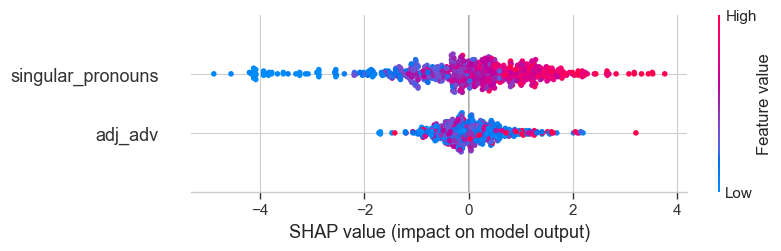

In [19]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [20]:
#shap.initjs()
#shap.force_plot(shap_values[:1000])